# CNN-VAE on HUTUBS depth maps

In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import os
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from IPython.display import display

from utils_data import load_hutubs_1_ears
from utils_model import create_model_fconv_inception
from utils_train import train_model_2d
from utils_plot import plot_reconstructions, plot_xcorr

In [5]:
# split main pandas dataframe into train and test sets,
# and into hrtfs, depthmaps, and anthropometrics
#
def split_sets(data, ids_train, ids_test):    
    # split dataframe
    data_filter_train = data['id'].isin(ids_train)
    data_filter_test  = data['id'].isin(ids_test)
    data_train = data[data_filter_train]
    data_test = data[data_filter_test]
    
    # depthmaps
    depth_train = np.stack(data_train['depthmap'].values)
    depth_test  = np.stack(data_test['depthmap'].values)
    
    # anthropometrics
    cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 
            'x12', 'x14', 'x16', 'x17', 'd1', 'd2', 'd3', 'd4', 
            'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'theta1', 'theta2']
    anthro_train = data_train[cols]
    anthro_test  = data_test[cols]
    
    # metadata (everything else)
    cols = ['id', 'ear', 'ear_n', 'azimuth', 'elevation']
    meta_train = data_train[cols]
    meta_test  = data_test[cols]
    
    # printo infos
    print(f'Split train/test: {len(ids_train)}/{len(ids_test)}')
    print(f'Train set: {data_train.shape}')
    print(f'Test set: {data_test.shape}')
    return (depth_train, anthro_train, meta_train), (depth_test, anthro_test, meta_test)

In [6]:
## SETTINGS 
# experiment settings
viable_ids_img = [ 10, 11, 12, 16, 19, 20, 21, 22, 23, 29, 2, 30, 31, 
    32, 33, 3, 40, 41, 44, 45, 46, 47, 48, 49, 4, 55, 57, 
    58, 59, 5, 60, 61, 62, 63, 66, 67, 68, 69, 6, 70, 71, 
    72, 73, 76, 77, 78, 80, 81, 82, 89, 8, 90, 91, 95, 9]
ids = np.array(viable_ids_img)
filters = {
    'ids': ids,
    #'ears': ['left'],
    'azimuths': [0],
    'elevations': [0]
}

print('- Choosen IDs: ', ids)
print('- Filters: ', filters)

- Choosen IDs:  [10 11 12 16 19 20 21 22 23 29  2 30 31 32 33  3 40 41 44 45 46 47 48 49
  4 55 57 58 59  5 60 61 62 63 66 67 68 69  6 70 71 72 73 76 77 78 80 81
 82 89  8 90 91 95  9]
- Filters:  {'ids': array([10, 11, 12, 16, 19, 20, 21, 22, 23, 29,  2, 30, 31, 32, 33,  3, 40,
       41, 44, 45, 46, 47, 48, 49,  4, 55, 57, 58, 59,  5, 60, 61, 62, 63,
       66, 67, 68, 69,  6, 70, 71, 72, 73, 76, 77, 78, 80, 81, 82, 89,  8,
       90, 91, 95,  9]), 'azimuths': [0], 'elevations': [0]}


In [25]:
# load HRTFs from HUTUBS 
from sklearn.model_selection import train_test_split
time.sleep(0.2)
data = load_hutubs_1_ears(filters)
ids_train, ids_test = train_test_split(filters['ids'])
(depth_train, anthro_train, meta_train), (depth_test, anthro_test, meta_test) = split_sets(data, ids_train, ids_test)
time.sleep(0.2)

100%|██████████| 110/110 [00:01<00:00, 86.91it/s]


Split train/test: 41/14
Train set: (82, 33)
Test set: (28, 33)


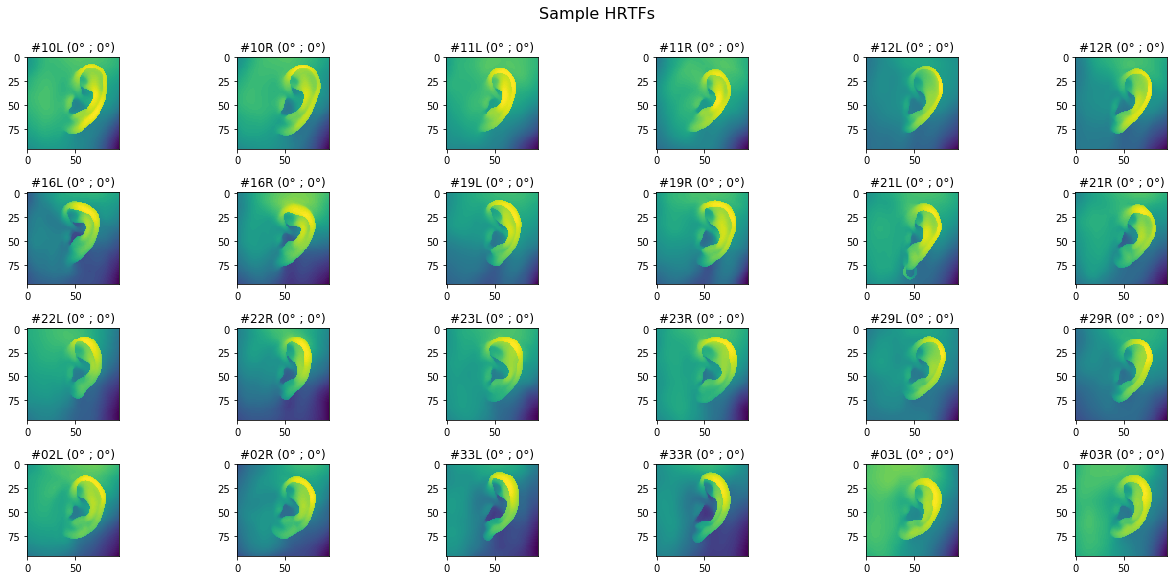

In [8]:
nr, nc = 4, 6
w = 18
h = w / 2.2
offs = 30

fig, ax = plt.subplots(nr, nc, figsize=(w, h))
for i, a in enumerate(ax.flatten()):
    a.imshow(depth_train[i])
    a.set_title('#{:02}{} ({:.0f}° ; {:.0f}°)'.format(
            meta_train['id'].iloc[i], meta_train['ear'].iloc[i][0].upper(),
            meta_train['azimuth'].iloc[i], meta_train['elevation'].iloc[i]))    
    
    #a.axis('off')
fig.suptitle('Sample HRTFs', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.94])


## Create network

In [27]:
depth_shape = (depth_train.shape[1], depth_train.shape[2], 1)
x_train = np.reshape(depth_train, [-1, *depth_shape])
x_test = np.reshape(depth_test, [-1, *depth_shape])
print(x_train.shape, x_test.shape)

# network parameters
filters_layers = [32, 64]
n_latent = 16

# create 1d net
encoder, decoder, vae = create_model_fconv_inception(input_shape=depth_shape, 
                                                    filters_layers=filters_layers, 
                                                    kernel_size=3,
                                                    n_latent=n_latent,
                                                    use_batchnorm=True, 
                                                    use_maxpool=True,
                                                    gen_plots=True)

# pre-compute some info for training
curr_epoch = 0
log_id = int(time.time()) % 99999999
tensorboard_destination = f'./logs/{log_id}'


(82, 96, 96, 1) (28, 96, 96, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
encoder_0_conv (Conv2D)         (None, 96, 96, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_0_1x1 (Conv2D)          (None, 96, 96, 32)   1056        encoder_0_conv[0][0]             
__________________________________________________________________________________________________
encoder_0_bnorm (BatchNormaliza (None, 96, 96, 32)   128         encoder_0_1x1[0][0]              
_____________________________________________________________________________

## Train network

In [46]:
# training parameters
batch_size = depth_train.shape[0] // 64
print(batch_size)
epochs = 300
validation_freq = 5
earlystopping_patience = -50
checkpoint_destination = None #'./models/{epoch.h5}'
cuda_device = '2'
tqdm_bar = True
# train the autoencoder
epochs_range = [curr_epoch, curr_epoch+epochs]
print(f'Training log: {tensorboard_destination}')
print(f'Training from {epochs_range[0]} to {epochs_range[1]}..')
trainig_history = train_model_2d(vae, x_train, x_test,
                              batch_size, epochs_range=epochs_range,
                              validation_freq=validation_freq,
                              tqdm_bar=tqdm_bar,
                              earlystopping_patience=earlystopping_patience, 
                              checkpoint_destination=checkpoint_destination, 
                              tensorboard_destination=tensorboard_destination, 
                              cuda_device=cuda_device)

curr_epoch += trainig_history.index[-1]

1
Training log: ./logs/78073567
Training from 398 to 698..


loss: 19.5829, val_loss: 113.3708:  89%|████████▉ | 267/300 [05:05<00:37,  1.14s/it]


## Plot results

minimum loss:  19.31573265354808


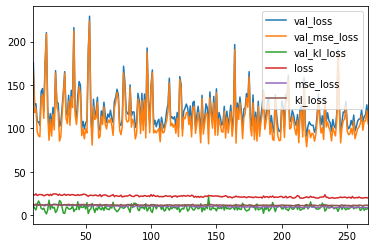

In [50]:
trainig_history.iloc[10:].plot()
print('minimum loss: ', trainig_history['loss'].min())

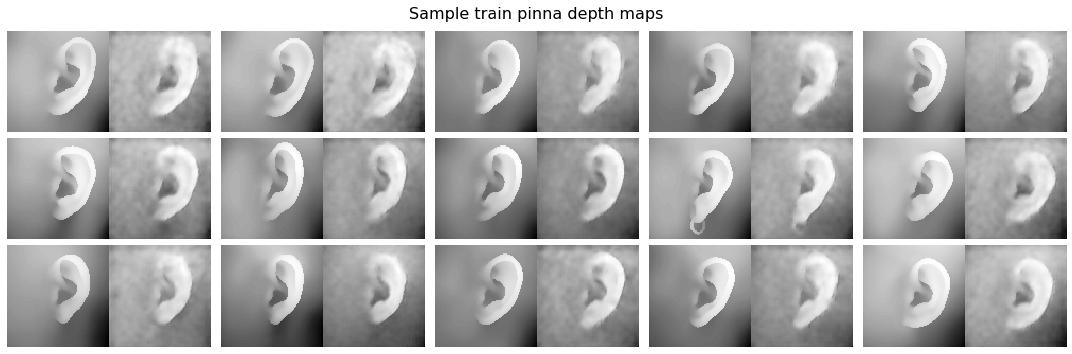

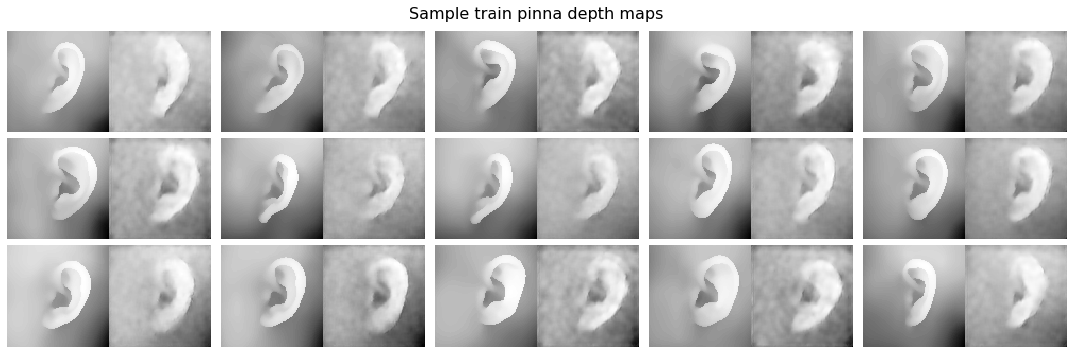

In [51]:
# take data
data_train = (x_train, meta_train)
data_test = (x_test, meta_test)

# plot reconstructions
fig, axs = plt.subplots(3, 5, figsize=(15, 5))
plot_reconstructions(encoder, decoder, data_train, axs=axs, batch_size=batch_size)
fig.tight_layout()
fig.suptitle('Sample train pinna depth maps', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.95])

fig, axs = plt.subplots(3, 5, figsize=(15, 5))
plot_reconstructions(encoder, decoder, data_test, axs=axs, batch_size=batch_size)
fig.tight_layout()
fig.suptitle('Sample train pinna depth maps', fontsize=16)
fig.tight_layout(rect=[0,0,1,0.95])

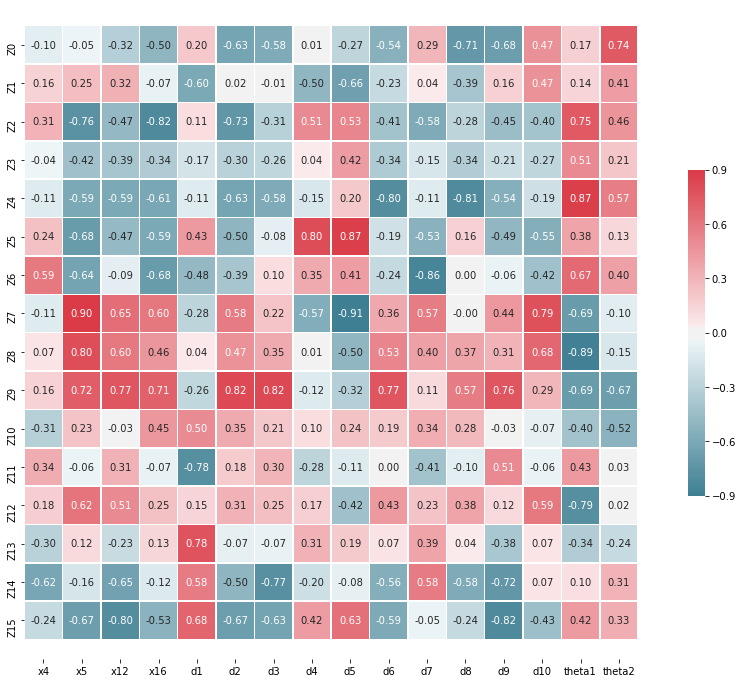

In [52]:
# data to use
drop_cols = ['x6', 'x7', 'x8', 'x9', 'x14', 'x17', 'x2', 'x3', 'x1']
#data_train = (x_train, y_train.drop(columns=['elevation', 'azimuth', 'xoffs', 'yoffs', *drop_cols]).astype(float))
data_train = (x_train, anthro_train.drop(columns=drop_cols).astype(float))
data_test = (x_test, anthro_test.drop(columns=drop_cols).astype(float))

# plot correlation
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
corr = plot_xcorr(encoder, data_test, ax,
           batch_size=batch_size, pca=False,
           labels=True)

[(0, array([0, 1])), (1, array([2, 3])), (2, array([4, 5])), (3, array([6, 7])), (4, array([8, 9])), (5, array([10, 11])), (6, array([12, 13])), (7, array([14, 15]))]


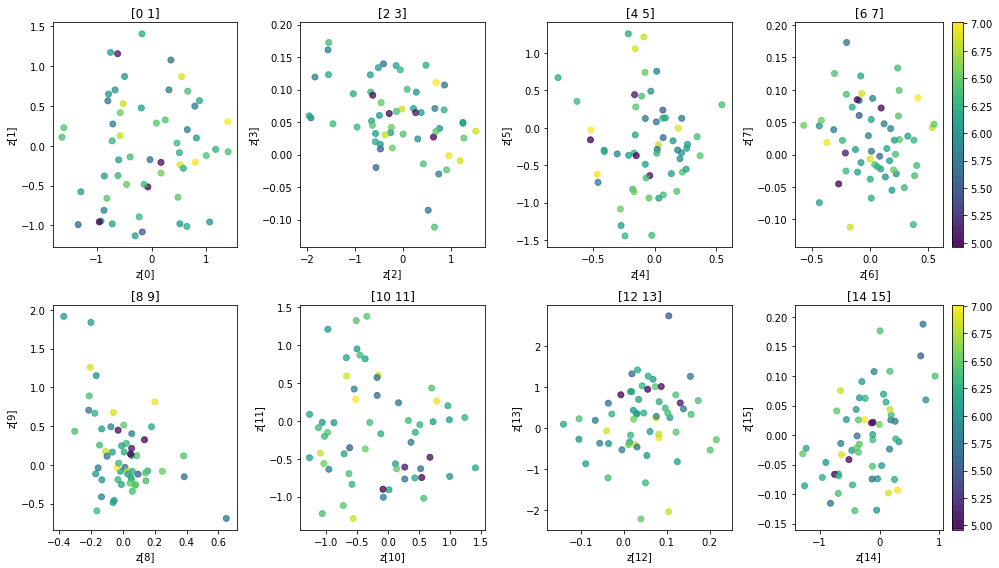

In [64]:
#data_train = (x_train, y_train['id'].astype('category').cat.codes)
#data_test = (x_test, y_test['id'].astype('category').cat.codes)
data_train = (x_train, anthro_train['d5'])

# plot latent dims
fig, axs = plt.subplots(2, n_latent//4, figsize=(14, 8))
combinations = np.arange(n_latent).reshape((n_latent//2, 2))
print(list(enumerate(combinations)))
for i, dims in enumerate(combinations):
#for i, dims in [(0, np.array([5, 7]))]:
    dims += 0
    plot_latent_space(encoder, data_train, axs.flatten()[i],
                      batch_size=batch_size, dims=dims,
                      colorbar=(i%4==3), use_pca=False)
fig.tight_layout()